In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from sunbird.emulators import FCN, train
from sunbird.data import ArrayDataModule


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [91]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
data_dir = Path('/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/')
data_fn = Path(data_dir) / 'training_sets/tpcf/z0.5/yuan23_prior/cosmopower/tpcf.npy'
lhc_y = np.load(data_fn, allow_pickle=True,).item()

In [5]:
s = lhc_y['s']
lhc_y = lhc_y['multipoles']
lhc_x = pd.read_csv(data_dir / 'hod_params/yuan23/hod_params_yuan23_c000.csv')
lhc_x_names = list(lhc_x.columns)
lhc_x_names = [name.replace(' ', '').replace('#', '') for name in lhc_x_names]
lhc_x = lhc_x.values[:len(lhc_y),:]

In [6]:
# let's keep a few points for testing the model
lhc_train_y = lhc_y[:-3000]
lhc_train_x = lhc_x[:-3000]

lhc_test_y = lhc_y[-3000:]
lhc_test_x = lhc_x[-3000:]

In [7]:
train_mean = np.mean(lhc_y, axis=0)
train_std = np.std(lhc_y, axis=0)

train_mean_x = np.mean(lhc_x, axis=0)
train_std_x = np.std(lhc_x, axis=0)


In [8]:
batch_size = 256
num_workers = 4
validation_fraction = 0.2

data = ArrayDataModule(
    x=torch.Tensor(lhc_train_x),
    y=torch.Tensor(lhc_train_y), 
    val_fraction=validation_fraction,
    batch_size=batch_size,
    num_workers=num_workers,
)
data.setup()

In [45]:
model = FCN(
    n_input=data.n_input,
    n_output=data.n_output,
    n_hidden=[512, 512, 512, 512],
    dropout_rate=0., 
    learning_rate=1.e-3,
    act_fn='learned_sigmoid',
    loss='rmse',
    training=True,
    mean_output=train_mean,
    std_output=train_std,
    mean_input=train_mean_x,
    std_input=train_std_x,
)


In [46]:
model.state_dict().keys()

odict_keys(['mean_input', 'std_input', 'mean_output', 'std_output', 'mlp.mlp0.weight', 'mlp.mlp0.bias', 'mlp.act0.alpha', 'mlp.act0.beta', 'mlp.mlp1.weight', 'mlp.mlp1.bias', 'mlp.act1.alpha', 'mlp.act1.beta', 'mlp.mlp2.weight', 'mlp.mlp2.bias', 'mlp.act2.alpha', 'mlp.act2.beta', 'mlp.mlp3.weight', 'mlp.mlp3.bias', 'mlp.act3.alpha', 'mlp.act3.beta', 'mlp.mlp4.weight', 'mlp.mlp4.bias'])

In [10]:
val_loss, model, early_stop_callback = train.fit(
    model=model,
    data=data, 
    model_dir='tpcf_example/',
    max_epochs=60,
)

[rank: 0] Seed set to 42
/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /n/holystore01/LABS/iaifi_lab/Lab/environments/carol ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker n

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: floppy. Use `wandb login --relogin` to force relogin


/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /n/home11/ccuestalazaro/sunbird/nb/tpcf_example exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


┏━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ mlp  │ Sequential │  850 K │
└───┴──────┴────────────┴────────┘

Trainable params: 850 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 850 K                                                                                                
Total estimated model params size (MB): 3

Output()

/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/site-packages/torch/utils/data/da
taloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of 
worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that 
excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid 
potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/multiprocessing/popen_fork.py:66:
RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, 
so this will likely lead to a deadlock.
  self.pid = os.fork()

Metric val_loss improved. New best score: 0.702


Metric val_loss improved by 0.169 >= min_delta = 1e-07. New best score: 0.533


Metric val_loss improved by 0.064 >= min_delta = 1e-07. New best score: 0.470


Metric val_loss improved by 0.125 >= min_delta = 1e-07. New best score: 0.345


Metric val_loss improved by 0.021 >= min_delta = 1e-07. New best score: 0.324


Metric val_loss improved by 0.029 >= min_delta = 1e-07. New best score: 0.294


Metric val_loss improved by 0.010 >= min_delta = 1e-07. New best score: 0.284


Metric val_loss improved by 0.067 >= min_delta = 1e-07. New best score: 0.217


Metric val_loss improved by 0.007 >= min_delta = 1e-07. New best score: 0.210


Metric val_loss improved by 0.003 >= min_delta = 1e-07. New best score: 0.207


Metric val_loss improved by 0.030 >= min_delta = 1e-07. New best score: 0.177


Metric val_loss improved by 0.004 >= min_delta = 1e-07. New best score: 0.173


Metric val_loss improved by 0.001 >= min_delta = 1e-07. New best score: 0.173


Metric val_loss improved by 0.002 >= min_delta = 1e-07. New best score: 0.170


Metric val_loss improved by 0.013 >= min_delta = 1e-07. New best score: 0.157


Metric val_loss improved by 0.011 >= min_delta = 1e-07. New best score: 0.146


: 

In [ ]:
print('best score = ', early_stop_callback.best_score.item())
print('stopped epoch = ', early_stop_callback.stopped_epoch)
print('wait count = ', early_stop_callback.wait_count)


best score =  0.5705341100692749
stopped epoch =  0
wait count =  0


In [30]:
# To load a model:
checkpoint_fn = "tpcf_example/best-model-epoch=278-val_loss=0.09.ckpt"

In [56]:
model = FCN.load_from_checkpoint(checkpoint_fn,strict=True,)
model = model.to('cpu')

In [57]:
# and now let's test it
model.eval()
with torch.no_grad():
    pred_test_y  = model.get_prediction(torch.Tensor(lhc_test_x))
pred_test_y = pred_test_y.numpy()

Text(0, 0.5, '$r^2 \\xi(r)$')

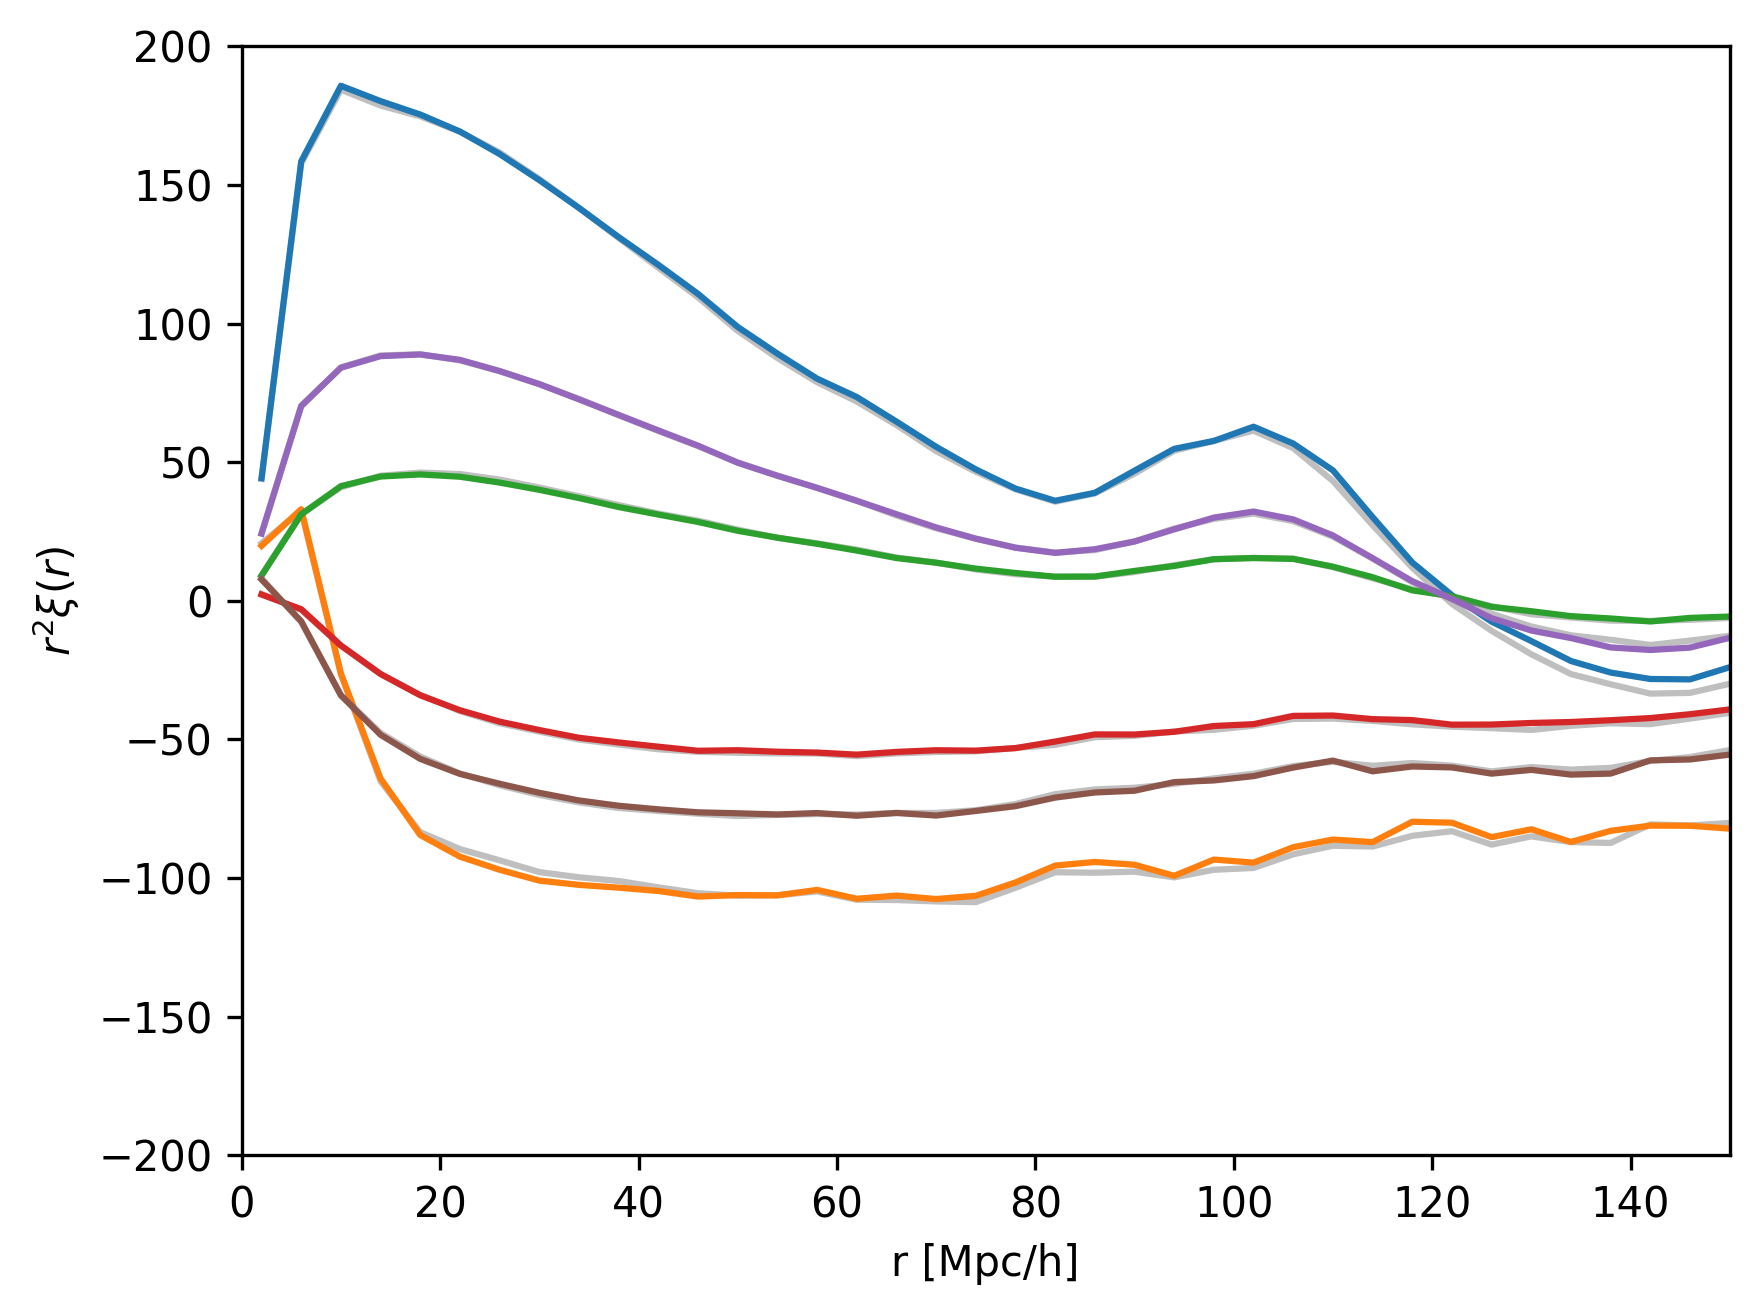

In [58]:

# let's plot some predictions vs truth
for i in range(3):
    plt.plot(
        s,
        s**2*pred_test_y[i,:50],
        color='gray',
        alpha=0.5,
    )
    plt.plot(
        s,
        s**2*pred_test_y[i,50:],
        color='gray',
        alpha=0.5,
    )

    plt.plot(s, s**2*lhc_test_y[i,:50], label='Observed')
    plt.plot(s, s**2*lhc_test_y[i,50:])


plt.xlim(0,150)
plt.ylim(-200,200)
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$r^2 \xi(r)$')

In [59]:
# now load jax model
nn_model, nn_params = model.to_jax()

In [61]:
jax_pred, _  = nn_model.apply(
    nn_params,
    lhc_test_x,
)

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Reading 1000 covariance files


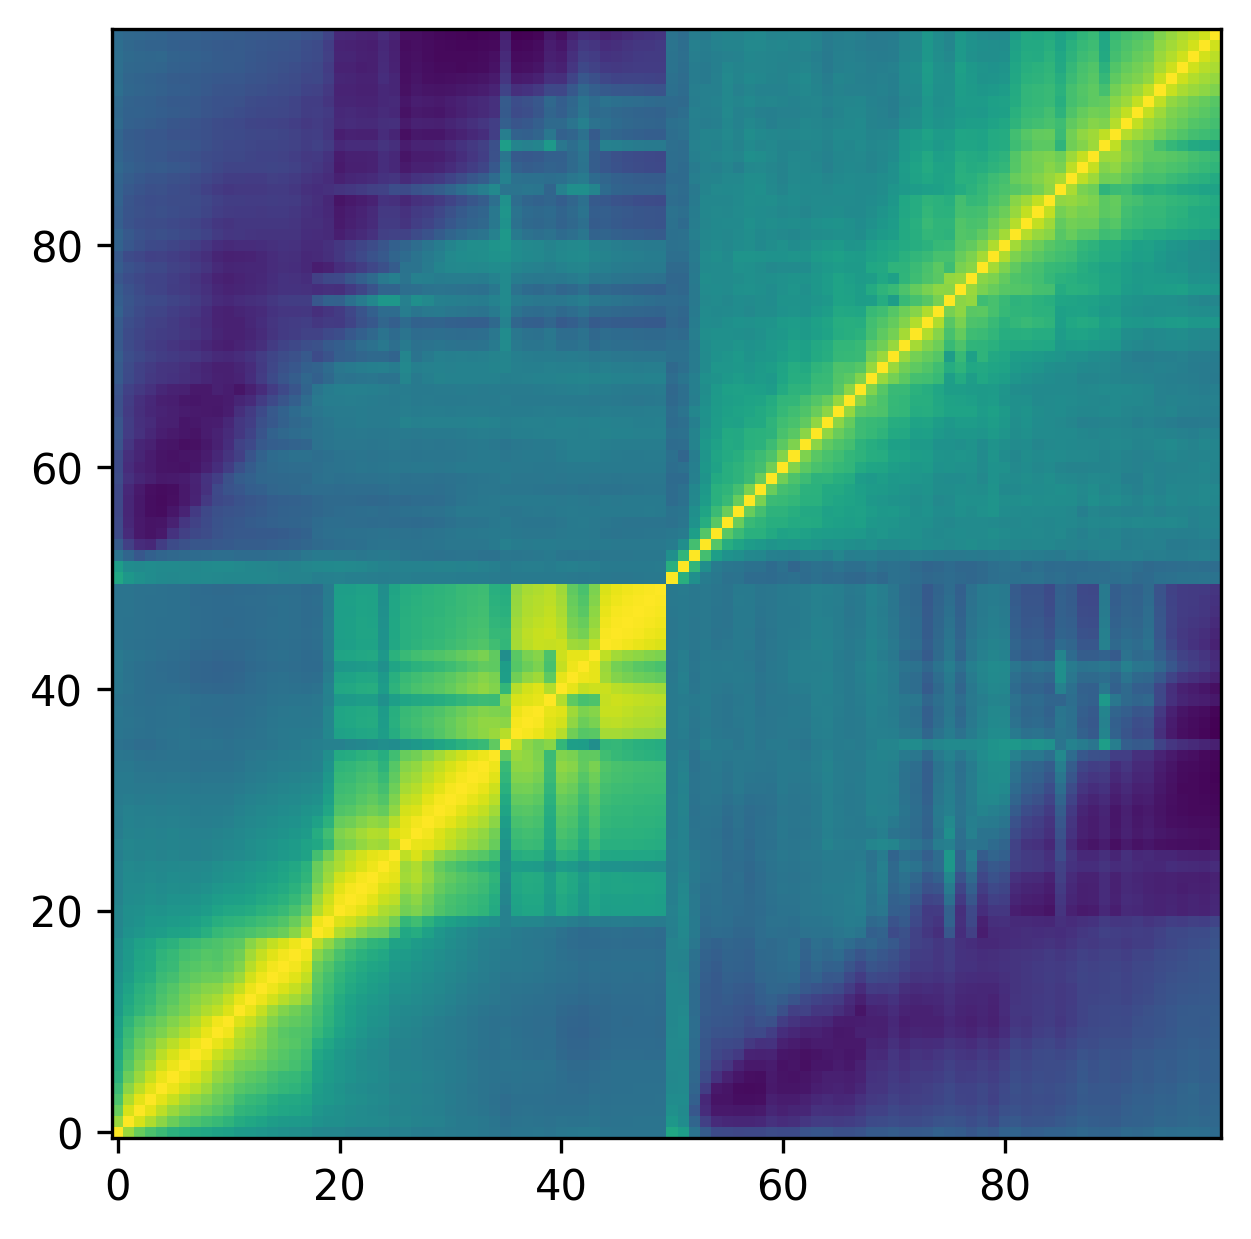

In [63]:
# and now let's compare the emulator errors to cosmic variance
from pycorr import TwoPointCorrelationFunction

covariance_path = data_dir / 'covariance/tpcf/z0.5/yuan23_prior/'
n_for_covariance = 1_000
covariance_files = list(covariance_path.glob('*.npy'))[:n_for_covariance]


print(f'Reading {len(covariance_files)} covariance files')
covariance_y = [
    TwoPointCorrelationFunction.load(file)[::4](ells=(0,2),).reshape(-1) for file in covariance_files
]

prefactor = 1./8.
covariance_matrix = prefactor * np.cov(np.array(covariance_y).T)

correlation_matrix = np.corrcoef(np.array(covariance_y).T)

plt.imshow(correlation_matrix, origin='lower')

In [64]:
emulator_error = (pred_test_y - lhc_test_y)/np.sqrt(np.diag(covariance_matrix))
q68 = np.quantile(emulator_error, [0.16, 0.84], axis=0)
q95 = np.quantile(emulator_error, [0.025, 0.975], axis=0)
q99 = np.quantile(emulator_error, [0.005, 0.995], axis=0)

<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/tmp/ipykernel_4051057/3416532088.py:1: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(list(range(pred_test_y.shape[-1])), q95[0], q95[1], alpha=0.5, label='95\%',)
/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/tmp/ipykernel_4051057/3416532088.py:2: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(list(range(pred_test_y.shape[-1])), q68[0], q68[1], alpha=0.5, label='68\%',)


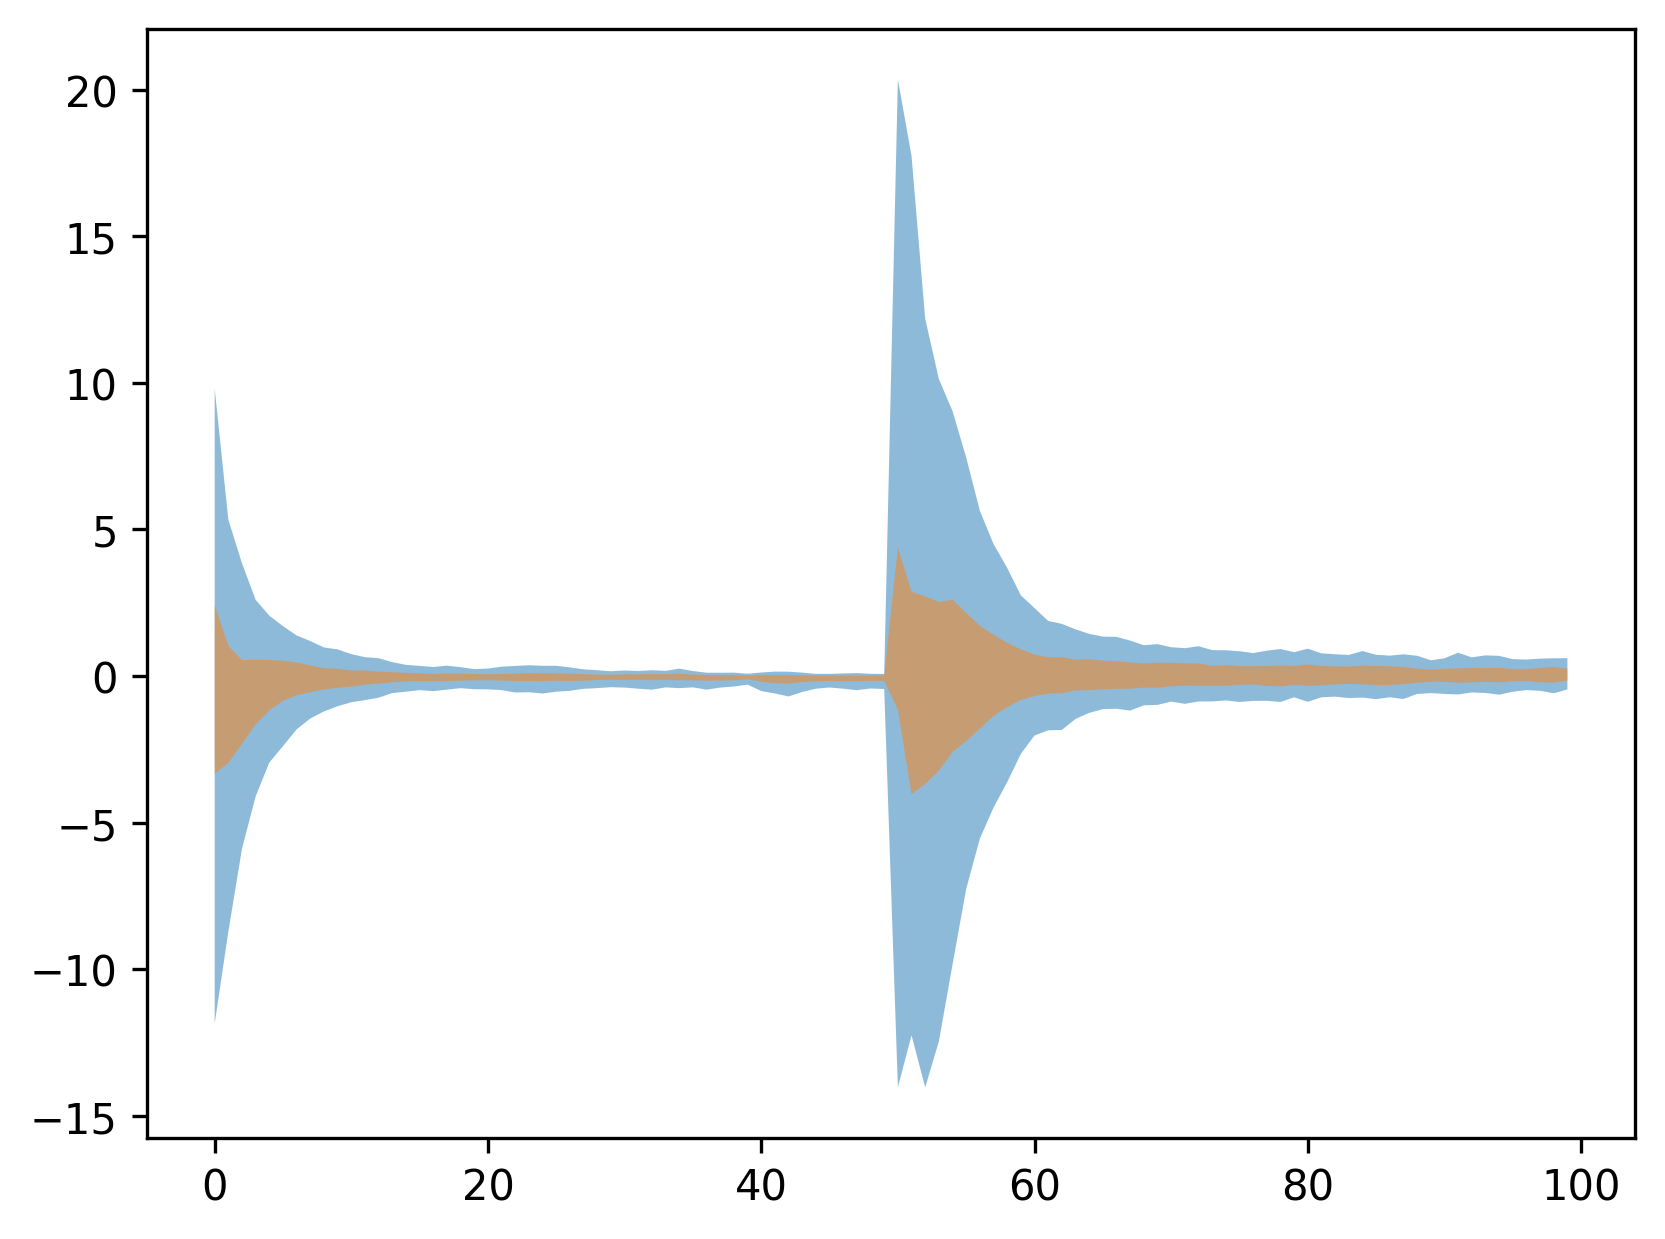

In [65]:

plt.fill_between(list(range(pred_test_y.shape[-1])), q95[0], q95[1], alpha=0.5, label='95\%',)
plt.fill_between(list(range(pred_test_y.shape[-1])), q68[0], q68[1], alpha=0.5, label='68\%',) 

In [68]:
from numpyro import distributions as dist
from sunbird.inference.hamiltonian import HMC

priors = {
    'logM1': dist.Uniform(low=13.6, high=15.1),
    'logM_cut': dist.Uniform(low=12.4, high=13.7),
    'alpha': dist.Uniform(low=0.3, high=1.5),
    'alpha_s': dist.Uniform(low=0.5, high=1.5),
    'alpha_c': dist.Uniform(low=0., high=0.5),
    'sigma': dist.Uniform(low=-3., high=1.),
    'kappa': dist.Uniform(low=0., high=1.),
    'B_cen': dist.Uniform(low=-0.7, high=0.2),
    'B_sat': dist.Uniform(low=-1., high=1.),
    'A_cen': dist.Uniform(low=-1., high=1.),
    'A_sat': dist.Uniform(low=-1., high=1.),
    's': dist.Uniform(low=-1., high=1.),
}
precision_matrix = np.linalg.inv(covariance_matrix)

In [69]:
idx_fit = 0
hmc = HMC(
    observation=lhc_test_y[idx_fit],
    precision_matrix=precision_matrix,
    nn_theory_model = nn_model,
    nn_parameters = nn_params,
    priors=priors,
)

In [71]:
posterior = hmc()

sample: 100%|██████████| 1100/1100 [00:42<00:00, 25.59it/s, 191 steps of size 6.06e-03. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     A_cen      0.18      0.01      0.18      0.17      0.19   1034.88      1.00
     A_sat      1.00      0.00      1.00      1.00      1.00    438.03      1.00
     B_cen      0.20      0.00      0.20      0.20      0.20    419.24      1.00
     B_sat     -0.96      0.00     -0.96     -0.96     -0.95   1118.77      1.00
     alpha      0.73      0.00      0.73      0.72      0.74    830.28      1.00
   alpha_c      0.03      0.01      0.03      0.02      0.04    701.37      1.00
   alpha_s      0.91      0.00      0.91      0.91      0.91   1190.58      1.00
     kappa      0.96      0.00      0.96      0.96      0.97    771.21      1.00
     logM1     14.29      0.00     14.29     14.28     14.29    689.17      1.00
  logM_cut     13.70      0.00     13.70     13.70     13.70    354.36      1.01
         s     -0.56      0.01     -0.56     -0.57     -0.55    998.79      1.00
     sigma     -0.20      0

In [95]:
from getdist import plots, MCSamples
posterior_array = np.stack(list(posterior.values()), axis=0)
chain_getdist = MCSamples(
        samples=posterior_array.T,
        weights=np.ones(posterior_array.shape[-1]),
        names=list(posterior.keys()),
    )

Removed no burn in


In [96]:
from getdist import plots
g = plots.get_subplot_plotter()
g.settings.constrained_layout = True
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = ":"
g.settings.title_limit_labels = False
g.settings.axis_marker_color = "k"
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth_contour = 1.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6

g.triangle_plot(
    roots=[chain_getdist],
    filled=True,
    markers=dict(zip(lhc_x_names, lhc_test_x[idx_fit]))
)
plt.show()